# Captcha Bypass

**Team 99**

Pranavbhai Patel

Nicholas Leung

Coden Mercurius

Ravi Singh

**Description**

CAPTCHA, or Completely Automated Public Turing Test to Tell Computers and Humans Apart, is a challenge-response test that determines whether a user is authentic (human) or inauthentic (machine). They require users to authenticate themselves by retyping a character sequence prior to completing a request. This notebook implements a CAPTCHA bypass using deep learning. The team aims to investigate weaknesses and vulnerabilities of the CAPTCHA system.

In [ ]:
import torch
import torch.nn as nn
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision 
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random

torch.manual_seed(0)
random.seed(0)

## Part 1. Data Processing

The dataset for this model is generated using the following library: https://github.com/lepture/captcha. No additional data augmentation is performed at this time. The code used to generate the dataset is found in the team private repo and is named `dataset_generator.py`.

**Primary Dataset Characteristics:**
- Uniform distribution of characters used
- 36 characters, 0-9 and A-Z
- 3000 captchas

**Secondary Dataset:**
- A dataset of a smaller character space is also availiable
- 10 numerical characters, 0-9
- 1981 captchas


The generated datasets are availiable through the team private repo. Upload `alphanumeric_dataset.zip` or `numeric_dataset.zip` into the root session storage and run the below cells to unzip. Update the path as needed.

In [ ]:
dataset_path = "/content/alphanumeric_dataset"

In [ ]:
!unzip  /content/alphanumeric_dataset2.zip -d /content/

In [ ]:
class CaptchaDataset(Dataset):
  """ Captcha Dataset """

  def __init__(self, directory):
    self.directory = directory
    self.captchas = os.listdir(directory)
    self.captchas.remove("metadata.txt")

    self.transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    self.character_set = open(directory + "/metadata.txt", "r").readline().split(',')
    self.characters_to_identifier = {}

    for i in range(len(self.character_set)):
      self.characters_to_identifier.update({ self.character_set[i]: i })

  def __len__(self):
    # Assumes each file in the dataset directory represents a data sample
    return len(self.captchas)

  def __getitem__(self, index):
    sample_name = self.captchas[index]
    sample_captcha_values = list(sample_name[0:-4]) # Slice s.t. remove png file extension

    # Read the image and represent it as a tensor
    image = io.imread(self.directory + '/' + sample_name)
    image = self.transform(image)

    # Represent each character as an integer identifier
    label = []
    for char in sample_captcha_values:
      label.append(self.characters_to_identifier.get(char))

    return (image, torch.tensor(label))

In [ ]:
# Instantiate dataset
dataset = CaptchaDataset(dataset_path)
character_set = dataset.character_set

character_frequency = {} # Contains frequency information

# Populate character_frequency
for _, label in dataset:
  for char_identifier in label:
    char = character_set[char_identifier.item()]
    current_value = character_frequency.get(char, None)

    if current_value is None: 
      character_frequency.update({ char : 0 })
    else:
      character_frequency.update({ char : current_value + 1 })

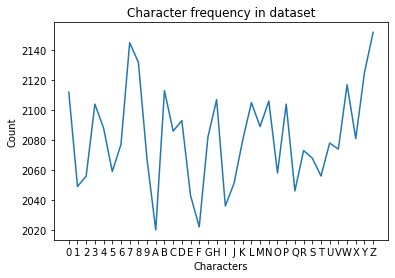

In [ ]:
# Dataset visualization

x_values = range(len(character_set))
y_values = []

for char in character_set:
  count = character_frequency.get(char)
  y_values.append(count)

plt.title("Character frequency in dataset")
plt.plot(x_values, y_values)
plt.xlabel("Characters")
plt.ylabel("Count")
plt.xticks(x_values, character_set)
plt.show()


In [ ]:
def get_data_loaders(dataset, batch_size):

  training_ratio = 0.7
  validation_ratio = 0.15
  # test_ratio implied

  train_length = int(len(dataset) * training_ratio)
  validation_length = int((len(dataset) - train_length) * (validation_ratio / ( 1 - training_ratio )))
  test_length = len(dataset) - train_length - validation_length
  
  train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_length, validation_length, test_length], torch.Generator().manual_seed(10))

  # REMINDER: Data is not shuffled per epoch, we may want this
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=1)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

  return train_loader, valid_loader, test_loader


## Part 2. Captcha Segmentation

This module performs captcha segmentation which is leveraged in the final captcha solver product. Using OpenCV Contour recognition, a given captcha image is segmented into its individual characters.


In [ ]:
import random
import cv2
import torchvision as tv

In [ ]:
class Chars2(nn.Module):
    def __init__(self):
        super(Chars2, self).__init__()
        self.conv1 = nn.Conv2d(1,7,5,1,4)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(7, 14, 5,1, 4)
        self.pool2 = nn.MaxPool2d(2,2)
        

        self.conv3 = nn.Conv2d(14, 28, 5,1, 4)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(28, 56, 5,1, 4)
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(56, 70, 5,1, 4)
        self.pool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(70, 80, 5,1, 4)
        self.pool6 = nn.MaxPool2d(2,2)
        


        self.fc1 = nn.Linear(2000, 100)
        self.fc2 = nn.Linear(100, 1)

        self.lrelu=torch.nn.LeakyReLU(-0.001)

    def forward(self, img):
        x = self.pool1(self.lrelu(self.conv1(img)))
        x = self.pool2(self.lrelu(self.conv2(x)))
        x = self.pool3(self.lrelu(self.conv3(x)))
        x = self.pool4(self.lrelu(self.conv4(x)))
        #print(x.shape)
        x = self.pool5(self.lrelu(self.conv5(x)))
        #print(x.shape)
        x = self.pool6(self.lrelu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 2000)
        x = self.fc2(self.lrelu(self.fc1(x)))
        return x

In [ ]:
class Chars3(nn.Module):
    def __init__(self):
        super(Chars3, self).__init__()
        self.conv1 = nn.Conv2d(1,7,5,1,4)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(7, 14, 5,1, 4)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(14, 28, 5,1, 4)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(28, 56, 5,1, 4)
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(56, 70, 5,1, 4)
        self.pool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(70, 80, 5,1, 4)
        self.pool6 = nn.MaxPool2d(2,2)
        


        self.fc1 = nn.Linear(2000, 130)
        self.fc2 = nn.Linear(130, 2)

        self.lrelu=torch.nn.LeakyReLU(-0.001)

    def forward(self, img):
        print(img.shape)
        x = self.pool1(self.lrelu(self.conv1(img)))
        print(x.shape)
        x = self.pool2(self.lrelu(self.conv2(x)))
        print(x.shape)
        x = self.pool3(self.lrelu(self.conv3(x)))
        print(x.shape)
        x = self.pool4(self.lrelu(self.conv4(x)))
        print(x.shape)
        x = self.pool5(self.lrelu(self.conv5(x)))
        print(x.shape)
        x = self.pool6(self.lrelu(self.conv6(x)))
        print(x.shape)
        x = x.view(-1, 2000)
        x = self.fc2(self.lrelu(self.fc1(x)))
        return x

In [ ]:
"""Load Previously saved model weights"""
modelChars2=Chars2()
modelChars2.load_state_dict(torch.load('2Char.pth'))
modelChars3=Chars3()
modelChars3.load_state_dict(torch.load('3Char.pth'))

<All keys matched successfully>

In [ ]:
def processimage(image, thresh):
      #Format image type/ dimensions
      image=image.permute(1,2,0)
      image=image.numpy()
      imageorig=image
      
      #Modify image so contours/ borders can be easily found
      #Greyscale
      #plt.imshow(image)
      #plt.show()

      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

      #plt.imshow(image, cmap='gray')
      #plt.show()

      #Binary Threshold
      NA, image = cv2.threshold(image, thresh, 1, cv2.THRESH_BINARY)

      #plt.imshow(image, cmap='gray', vmin = 0, vmax = 1)
      #plt.show()

      #Erosion
      #kernel = np.ones((2,2),np.uint8)
      #image = cv2.dilate(image,kernel,iterations = 1)
      #Vertical Blur and Resharpen
      morpher = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
      #image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, morpher)
      image = cv2.dilate(image,morpher,iterations = 1)

      #plt.imshow(image, cmap='gray', vmin = 0, vmax = 1)
      #plt.show()

      image = cv2.erode(image,morpher,iterations = 1)

      #plt.imshow(image, cmap='gray', vmin = 0, vmax = 1)
      #plt.show()

      #Binary Threshold  
      thresh, image = cv2.threshold(image,thresh, 1, cv2.THRESH_BINARY)

      #plt.imshow(image, cmap='gray', vmin = 0, vmax = 1)
      #plt.show()

      #Expand Border
      image=cv2.copyMakeBorder(image, 5, 5, 5, 5,cv2.BORDER_CONSTANT,value=1)
      image = image.astype(np.uint8)

      #plt.imshow(image, cmap='gray', vmin = 0, vmax = 1)
      #plt.show()

      return imageorig,image

In [ ]:
def segmentimage(image,narrow):
    #Return list of borderlines in image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #imagecont=cv2.drawContours(image, contours, -1, (0, 0.5, 0), 1)

    #Creates boxes for every large object
    boxes=[]
    for contour in contours:
        [x,y,w,h]=cv2.boundingRect(contour)
        if(w>8 and w<120 and h>22):
          boxes.append([x,y,w,h])
    boxes.sort(key=lambda x: x[0])

    #Eliminates boxes that are contained whithin other boxes (subparts of a letter)
    i=1
    while (i<len(boxes)):
      box=boxes[i]
      boxprev=boxes[i-1]
      if (box[0]>boxprev[0] and box[1]>boxprev[1] and (box[0]+box[2])<(boxprev[0]+boxprev[2]) and (box[1]+box[3])<(boxprev[1]+boxprev[3])):
        boxes.pop(i)
        i-=1
      i+=1

    #If boxes are too wide they may contain multiple boxes 
    #They are split vertically into 2 or 3 subboxes (even width splits)
    i=0
    """while (i<len(boxes)):
      box=boxes[i]
      if (box[2]>box[3]*(0.95-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int((2*w)/3),y,int(w/3),h])
        boxes.insert(i,[x+int((w)/3),y,int(w/3),h])
        boxes.insert(i,[x,y,int(w/3),h])
      elif (box[2]>box[3]*(0.6-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int(w/2),y,int(w/2),h])
        boxes.insert(i,[x,y,int(w/2),h])
      if (i>=len(boxes)-1):
        break
      i+=1"""
    
    return boxes


    


In [ ]:
#Resizes an image according to the given dimensions. No distortion applied
def resizeimage(image,dheight,dwidth):
  height=image.shape[0]
  width=image.shape[1]
  if (width>height):
    topbuffer=int ((width-height)/2)
    topbufferoverwidth=float(topbuffer)/width
    sidebufferoverwidth=0
    image=cv2.copyMakeBorder(image,topbuffer,topbuffer, 0, 0,cv2.BORDER_CONSTANT,value=1)
  else:
    sidebuffer=int ((height-width)/2)
    sidebufferoverwidth=float(sidebuffer)/height
    topbufferoverwidth=0
    image=cv2.copyMakeBorder(image,0,0, int ((height-width)/2), int ((height-width)/2),cv2.BORDER_CONSTANT,value=1)
  image = cv2.resize(image, dsize=(dwidth, dheight), interpolation=cv2.INTER_CUBIC)
  return image,topbufferoverwidth,sidebufferoverwidth


In [ ]:
def getcharacterimages(images,dheight=80,dwidth=80, showsegments=False, deeplearning=False ):
  characters=[]
  for i in range (0,len(images)):
    imageraw = images[i]
 
    """CAPTCHA image pre-processed, custom function called"""
    # Rectangle Borders of each character obtained, custom function called
    # Binary Threshold is adaptably adjusted until image is seen
    thresh, narrow = 0.6,0
    for x in range(0,5):  
      imageorig, image=processimage(imageraw,thresh)
      imageboxes = np.copy(image)
      boxes=segmentimage(image,narrow)
      if (len(boxes)<=1):
        thresh+=x*0.1
      else:
        break
    
    """Estimating Characters per box"""
    # We estimate this number by the ratio of height to width
    # The ratio is adaptably adjusted until we meet 5 characters
    narrow=0 
    for x in range (0,200):
      numchars=[]
      narrow+=x*0.005
      for i in range(0,len(boxes)):
        box=boxes[i]
        if (box[2]>box[3]*(0.95-narrow)):
          numchars.append(3)
        elif (box[2]>box[3]*(0.7-narrow*0.66)):
          numchars.append(2)
        else:
          numchars.append(1)
      # Only break if 5 characters are estimated
      sum=0
      for j in range(0,len(numchars)):
        sum+=numchars[j]
      if (sum>=5):
        break
    
    #Add 0 estimates, if there are still less than 5 numchar estimates
    while (len(numchars)<5):
      numchars.append(0)

    """If deeplearning off, cut boxes"""
    if (deeplearning==False):
      boxnum=0
      for i in range(0,len(boxes)):
          #boxnum tracks boxes, i tracks numchars prediction
          box=boxes[boxnum]
          if (numchars[i]==3):
            x,y,w,h=boxes.pop(boxnum)
            boxes.insert(boxnum,[x+int((2*w)/3),y,int(w/3),h])
            boxes.insert(boxnum,[x+int((w)/3),y,int(w/3),h])
            boxes.insert(boxnum,[x,y,int(w/3),h])
            boxnum+=3
          elif (numchars[i]==2):
            x,y,w,h=boxes.pop(boxnum)
            boxes.insert(boxnum,[x+int(w/2),y,int(w/2),h])
            boxes.insert(boxnum,[x,y,int(w/2),h])
            boxnum+=2
          else:
            boxnum+=1


    #Filter bad segmentation cases
    #Update: Feature no longer possible
    #if filterBadSegmentation and len(boxes) < 5:
      #continue

    """Cutting out Box Images from CAPTCHA"""
    charactersset=[]
    for i in range(0,5):
      # If insufficient letters obtainable, add an empty image
      if (i<len(boxes)):
        box=boxes[i]
      else:
        box=[0,0,1,1]

      [x,y,w,h]=box
      char=image[y:y+h,x:x+w]
      height=char.shape[0]
      width=char.shape[1]
      # cv2.copyMakeBorder(soruce, top, bottom, left, right, borderType, value)

      #Resizing Image
      char,topbufferoverwidth,sidebufferoverwidth=resizeimage(char,80,80)


      """If deeplearning = True, use models to split images"""
      if (deeplearning==False):
        charactersset.append(char)
      else:
        if (numchars[i]==2):
          input=torch.Tensor(char).unsqueeze(0).unsqueeze(0)
          #Splitting Estimate from Model
          horsplit=round(modelChars2(input).item())
          if (topbufferoverwidth!=0):
            #Cut off excess top, split according to model prediction, resize
            char1=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),0:horsplit]
            char2=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),horsplit:]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
          else:
            #Cut off excess sides, split according to model prediction, resize
            char1=char[:,round(sidebufferoverwidth*80):horsplit]
            char2=char[:,horsplit:round(80-sidebufferoverwidth*80)]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
        elif (numchars[i]==3):
          input=torch.Tensor(char).unsqueeze(0).unsqueeze(0)
          #Splitting Estimate from Model
          output=modelChars3(input).squeeze()
          horsplit=round(output[0].item()),round(output[1].item())
          if (topbufferoverwidth!=0):
            #Cut off excess top, split according to model prediction, resize
            char1=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),0:horsplit[0]]
            char2=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),horsplit[0]:horsplit[1]]
            char3=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),horsplit[1]:]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            char3=resizeimage(char3,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
            charactersset.append(char3)
          else:
            #Cut off excess sides, split according to model prediction, resize
            char1=char[:,round(sidebufferoverwidth*80):horsplit[0]]
            char2=char[:,horsplit[0]:horsplit[1]]
            char3=char[:,horsplit[1]:round(80-sidebufferoverwidth*80)]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            char3=resizeimage(char3,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
            charactersset.append(char3)
        else:
          charactersset.append(char)


      #Draw Boxes
      cv2.rectangle(imageboxes,(x,y),(x+w,y+h),0,1)

    """Resizes Images accoring to the given dimensions"""
    for i in range(0,5):
      nchar=resizeimage(charactersset[i],dheight,dwidth)[0]
      charactersset[i]=torch.Tensor(nchar)

    charactersset=torch.stack(charactersset[0:5])
    characters.append(charactersset)
    
    
    
    """ShowSegments = True: Visualization of the entire process"""
    if (showsegments==True):
      plt.imshow(imageorig)
      plt.show()
      plt.imshow(imageboxes, cmap='gray', vmin = 0, vmax = 1)
      plt.show()

      print("      ",end="")
      for j in range(0,len(numchars)):
        print(numchars[j],end="        ")
      print("",end="")

      for i in range(0,len(charactersset)):
        plt.subplot(1,5,i+1)
        plt.imshow(charactersset[i], cmap='gray', vmin = 0, vmax = 1)
      plt.show()

  return torch.stack(characters)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


842


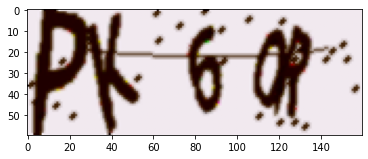

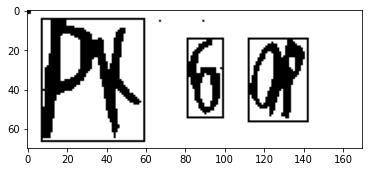

      2        1        2        0        0        

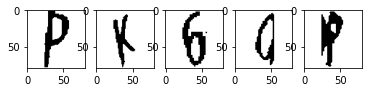

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[25, 20,  6, 24, 27]])
843


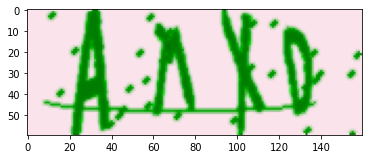

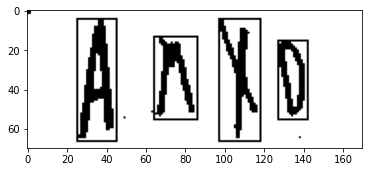

      1        2        1        1        0        

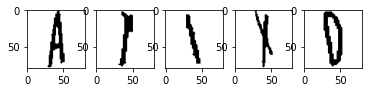

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[10, 29,  1, 33, 13]])
844


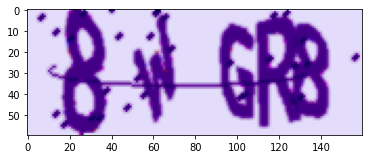

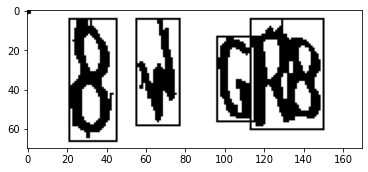

      1        1        1        2        0        

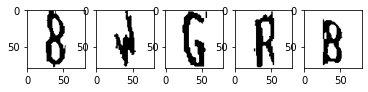

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 8, 32, 16, 27,  8]])
845


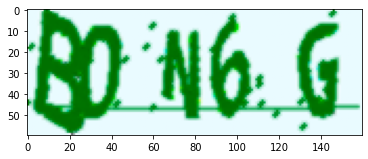

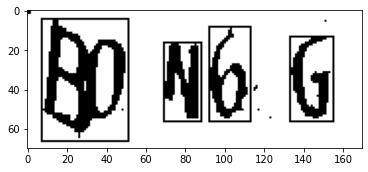

      2        1        1        1        0        

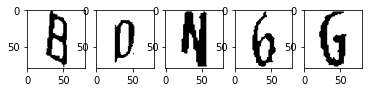

tensor([[11,  0, 23,  6, 16]])
846


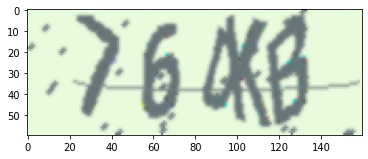

KeyboardInterrupt: ignored

In [ ]:
"""
How To Use - getcharacterimages(images,height,width, showsegments=False)

Input = tensor(batchsize,numchannels,height,width) (see below)
Output = tensor(batchsize, numcharacters = 5, height = 80, width = 80 )
"""
train, valid, test = get_data_loaders(dataset, 1)

images_processed = 0
successful_segmentation = 0

i=0
for images, labels in test:
  if (i>=842):
    #input dimensions should be a square
    print(i)
    characters = getcharacterimages(images,dheight=80,dwidth=80, showsegments=True, deeplearning=True)
    print(labels)
  i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


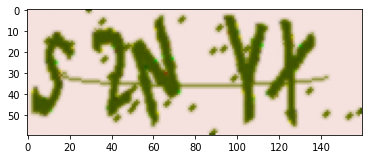

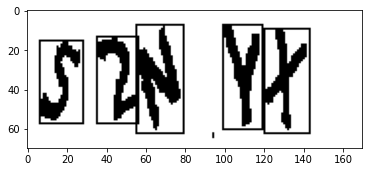

      1        1        1        1        1        

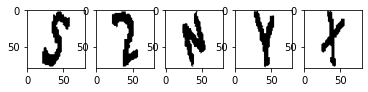

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


201
tensor([[28,  2, 23, 34, 33]])


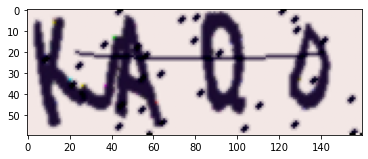

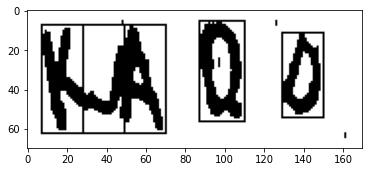

      3        1        1        0        0        

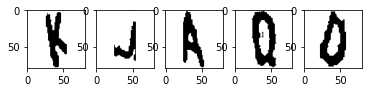

202
tensor([[20, 19, 10, 26, 13]])


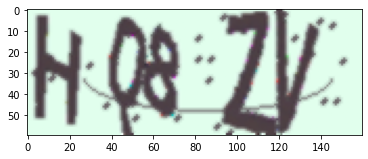

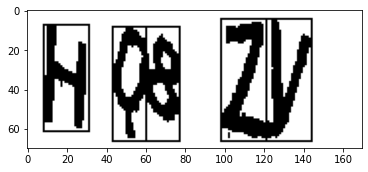

      1        2        2        0        0        

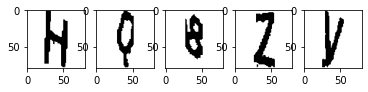

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


203
tensor([[17, 26,  8, 35, 31]])


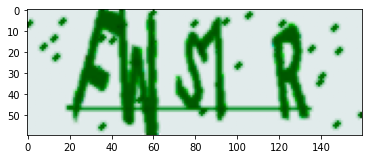

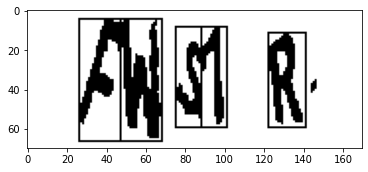

      2        2        1        0        0        

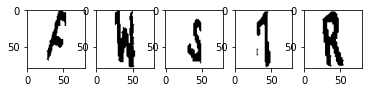

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


204
tensor([[15, 32, 28,  7, 27]])


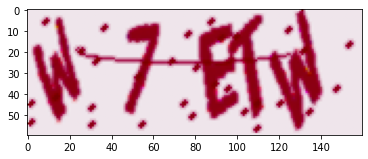

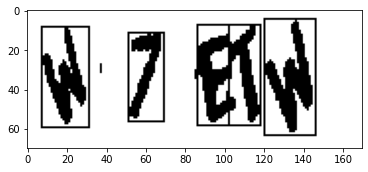

      1        1        2        1        0        

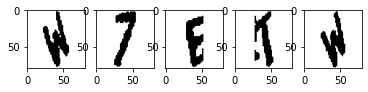

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


205
tensor([[32,  7, 14, 29, 32]])


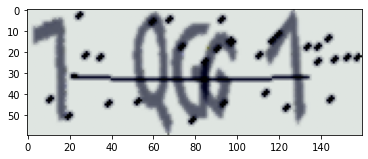

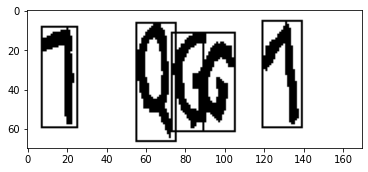

      1        1        2        1        0        

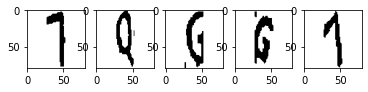

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


206
tensor([[ 7, 26, 16, 16,  7]])


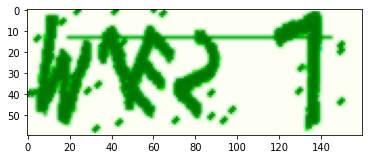

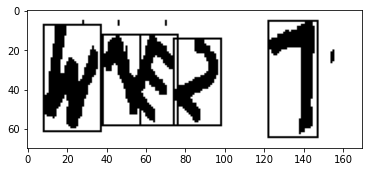

      1        2        1        1        0        

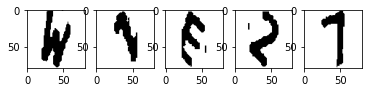

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


207
tensor([[32,  1, 14,  2,  7]])


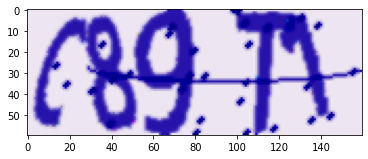

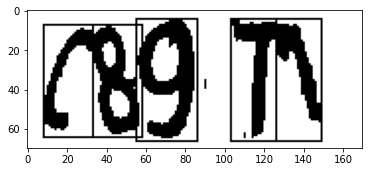

      2        1        2        0        0        

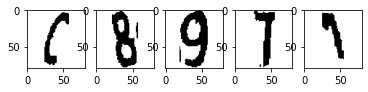

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


208
tensor([[12,  8,  9, 29,  1]])


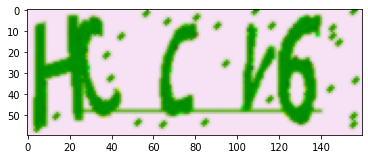

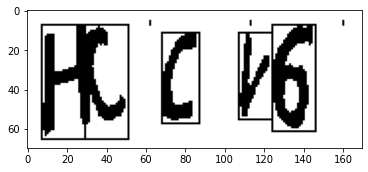

      2        1        1        1        0        

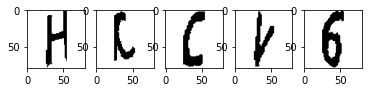

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


209
tensor([[17, 12, 12, 31,  6]])


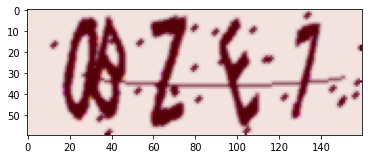

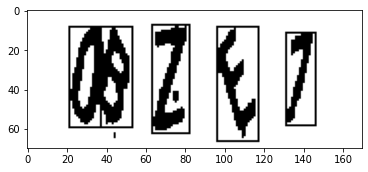

      2        1        1        1        0        

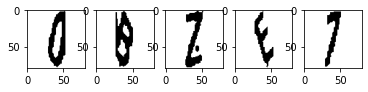

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


210
tensor([[ 0, 11, 35, 14,  7]])


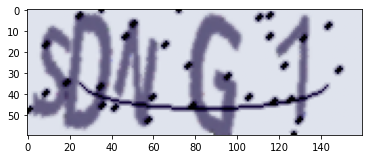

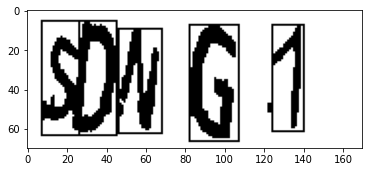

      2        1        1        1        0        

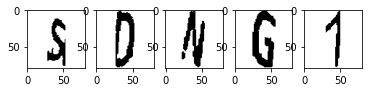

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


211
tensor([[28, 13, 23, 16,  7]])


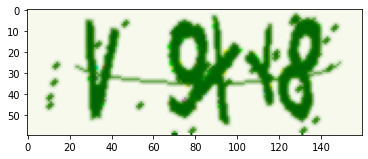

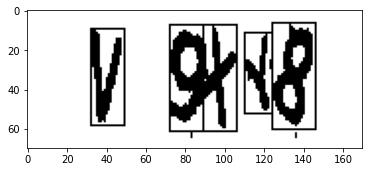

      1        2        1        1        0        

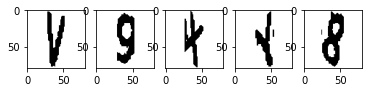

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


212
tensor([[31,  9, 33, 34,  8]])


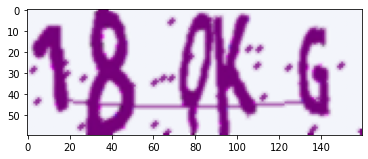

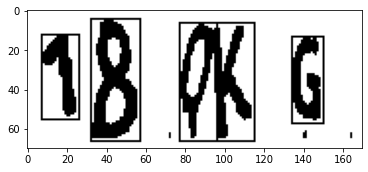

      1        1        2        1        0        

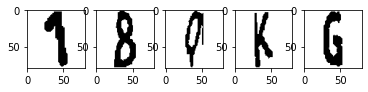

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


213
tensor([[ 1,  8, 26, 20, 16]])


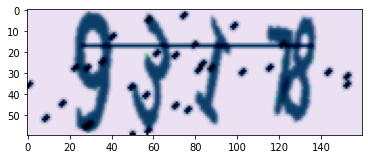

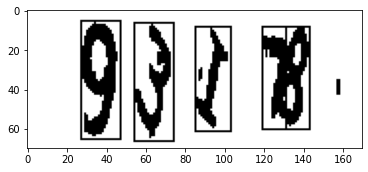

      1        1        1        2        0        

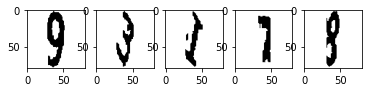

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


214
tensor([[ 9,  3, 18,  7,  8]])


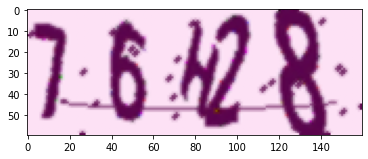

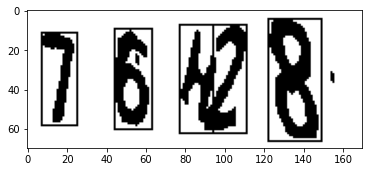

      1        1        2        1        0        

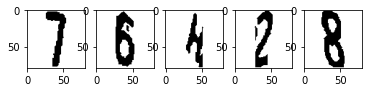

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


215
tensor([[ 7,  6, 17,  2,  8]])


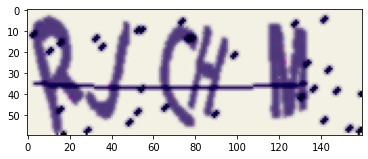

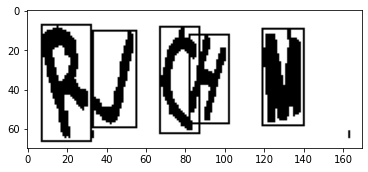

      1        1        1        1        1        

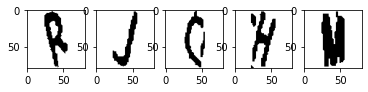

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


216
tensor([[27, 19, 12, 17, 22]])


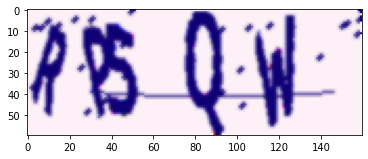

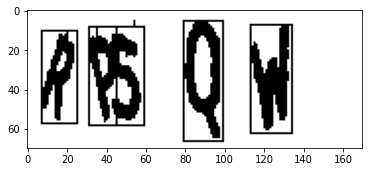

      1        2        1        1        0        

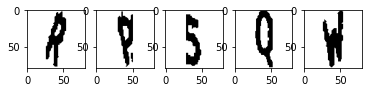

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


217
tensor([[27, 25,  5, 26, 32]])


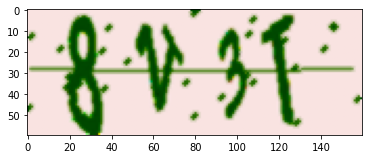

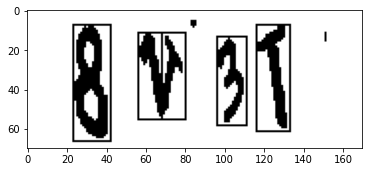

      1        2        1        1        0        

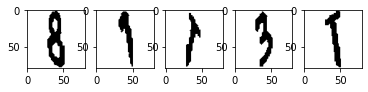

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


218
tensor([[ 8,  1, 29,  3, 29]])


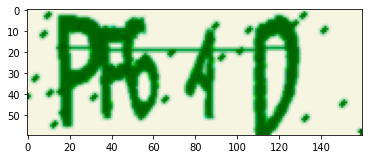

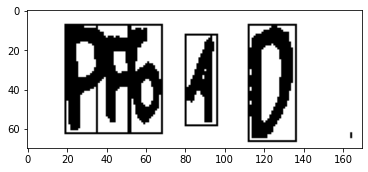

      3        1        1        0        0        

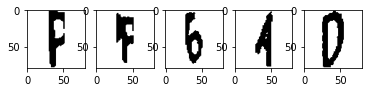

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


219
tensor([[25, 15,  6, 10, 13]])


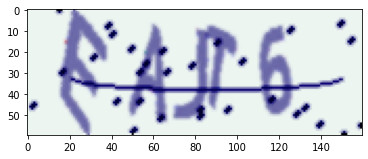

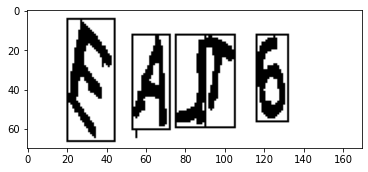

      1        1        2        1        0        

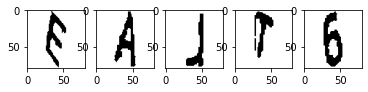

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


220
tensor([[14, 10, 19, 29,  6]])


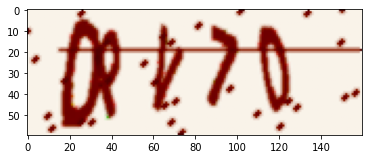

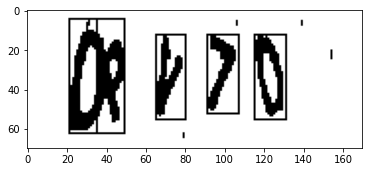

      2        1        1        1        0        

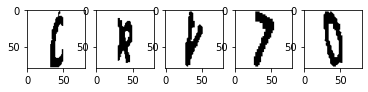

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


221
tensor([[24, 25, 31,  7,  0]])


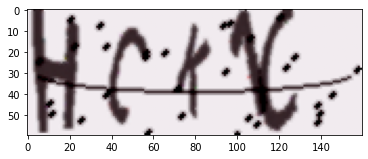

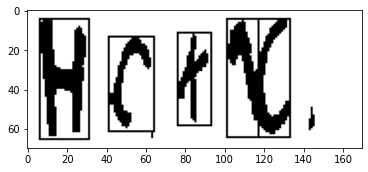

      1        1        1        2        0        

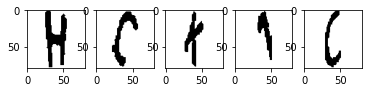

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


222
tensor([[17, 12, 20,  1, 12]])


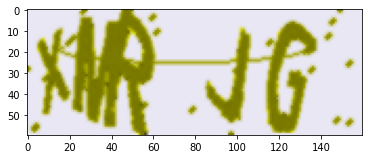

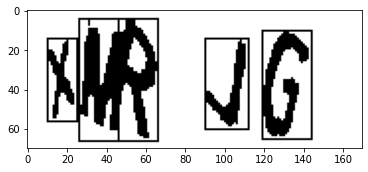

      1        2        1        1        0        

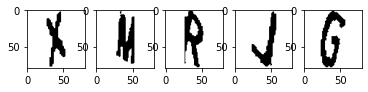

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


223
tensor([[33, 22, 27, 19, 16]])


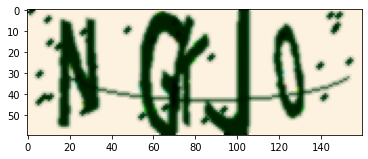

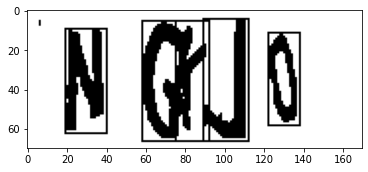

      1        2        1        1        0        

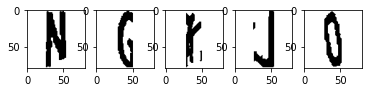

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


224
tensor([[23, 16, 20, 19, 24]])


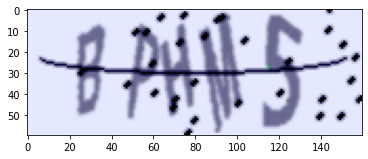

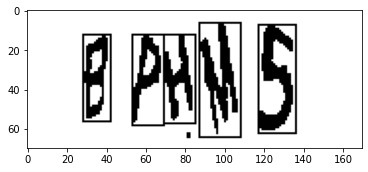

      1        1        1        1        1        

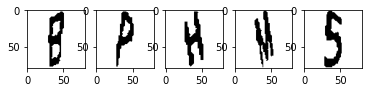

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


225
tensor([[11, 25, 17, 22,  5]])


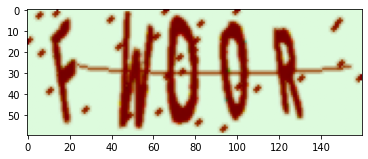

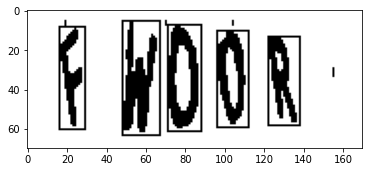

      1        1        1        1        1        

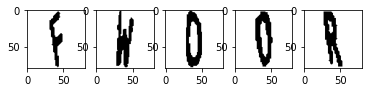

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


226
tensor([[15, 32, 24,  0, 27]])


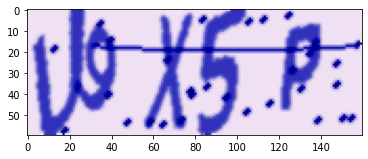

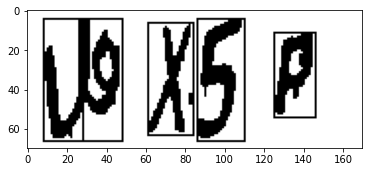

      2        1        1        1        0        

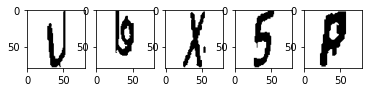

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


227
tensor([[30,  9, 33,  5, 25]])


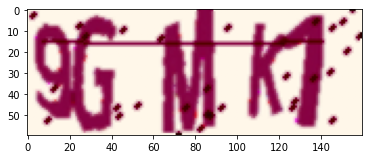

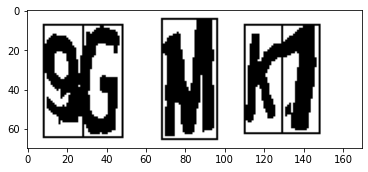

      2        1        2        0        0        

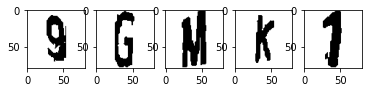

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


228
tensor([[ 9, 16, 22, 20,  1]])


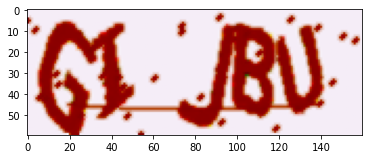

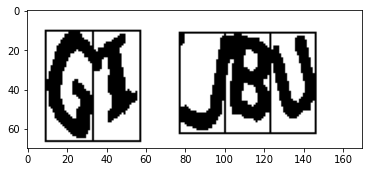

      2        3        0        0        0        

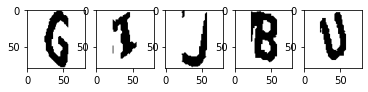

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


229
tensor([[16, 18, 19, 11, 30]])


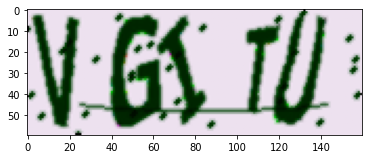

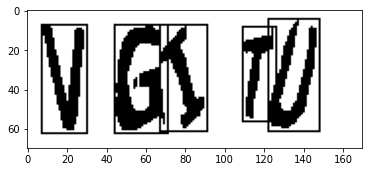

      1        1        1        1        1        

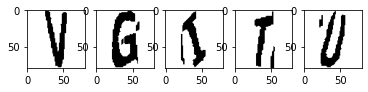

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


230
tensor([[31, 16, 18, 29, 30]])


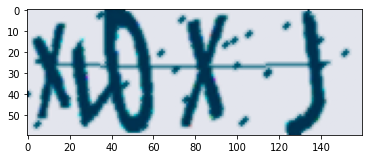

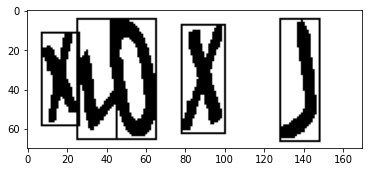

      1        2        1        1        0        

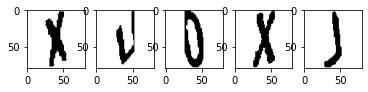

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


231
tensor([[33, 21,  0, 33, 19]])


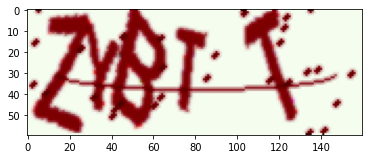

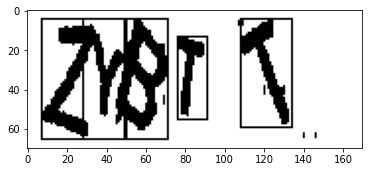

      3        1        1        0        0        

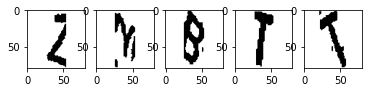

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


232
tensor([[35, 34, 11, 29, 29]])


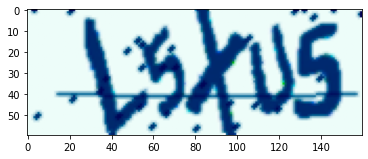

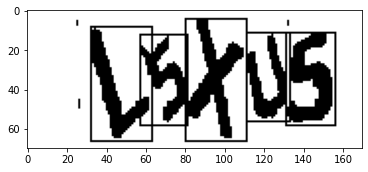

      1        1        1        1        1        

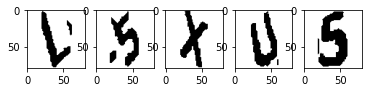

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


233
tensor([[21,  5, 33, 30,  5]])


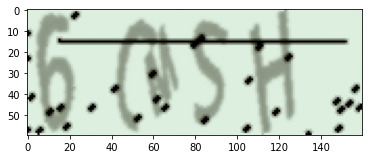

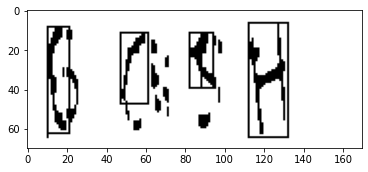

      1        1        2        1        0        

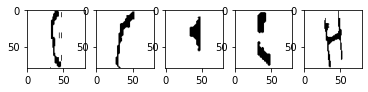

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234
tensor([[ 6, 12, 22, 28, 17]])


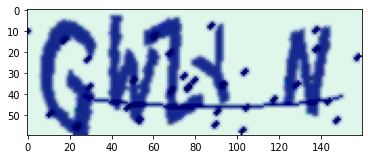

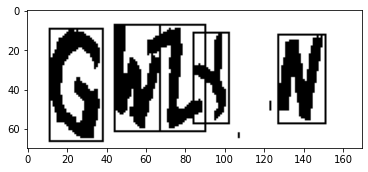

      1        2        1        1        0        

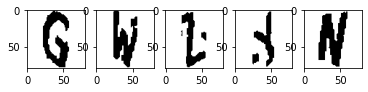

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


235
tensor([[16, 32, 35, 34, 23]])


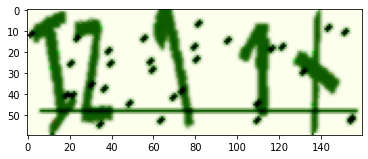

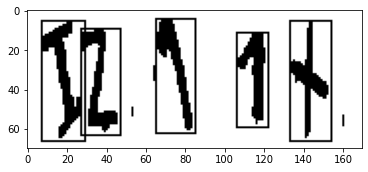

      1        1        1        1        1        

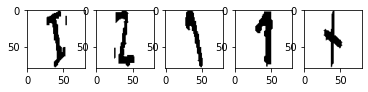

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


236
tensor([[18, 35,  1,  1, 33]])


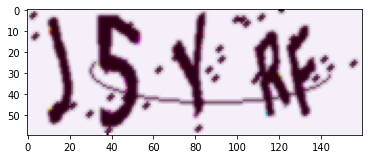

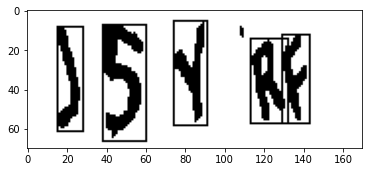

      1        1        1        1        1        

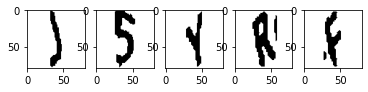

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


237
tensor([[19,  5, 34, 27, 15]])


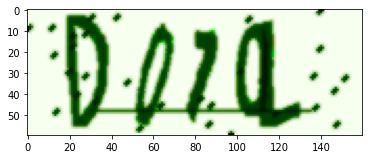

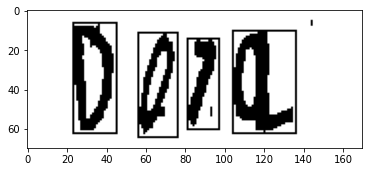

      1        1        1        2        0        

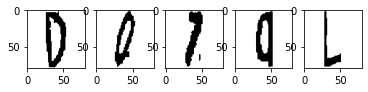

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


238
tensor([[13,  0,  1, 24, 21]])


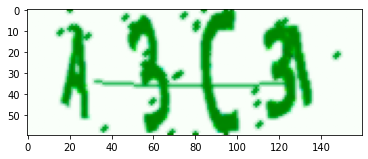

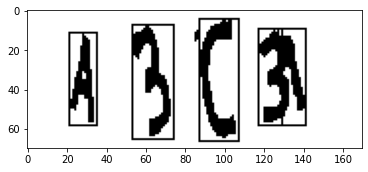

      1        1        1        2        0        

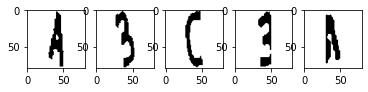

239
tensor([[10,  3, 12,  3,  1]])


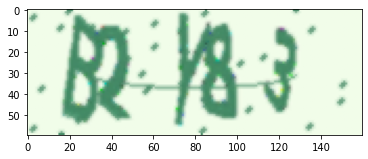

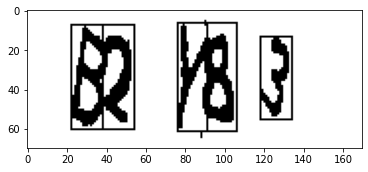

      2        2        1        0        0        

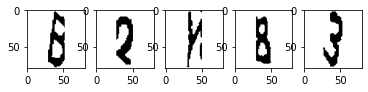

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


240
tensor([[11,  2, 34,  8,  3]])


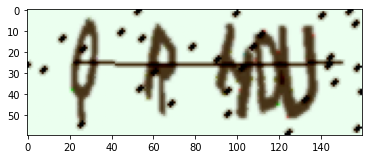

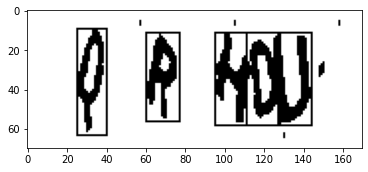

      1        1        3        0        0        

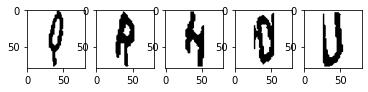

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


241
tensor([[26, 27, 17, 13, 30]])


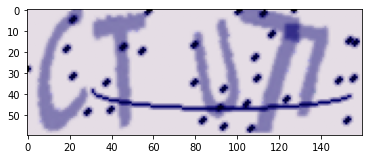

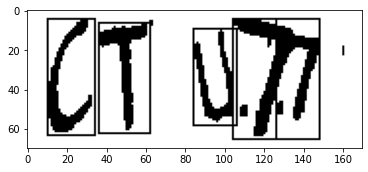

      1        1        1        2        0        

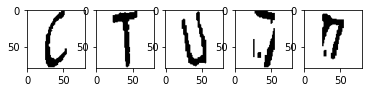

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


242
tensor([[12, 29, 30,  7,  7]])


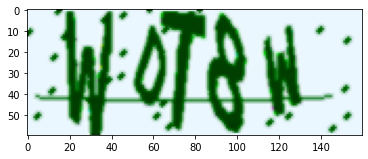

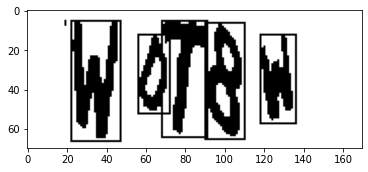

      1        1        1        1        1        

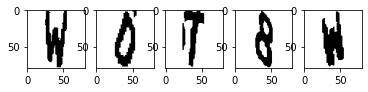

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


243
tensor([[32, 13, 29,  8, 32]])


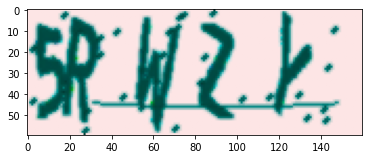

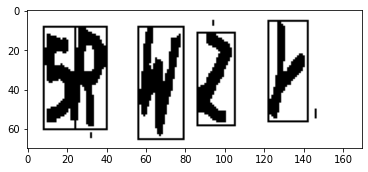

      2        1        1        1        0        

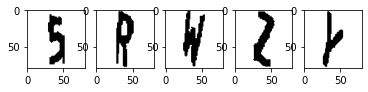

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


244
tensor([[ 5, 27, 32, 35, 34]])


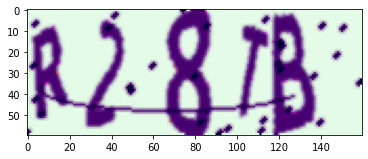

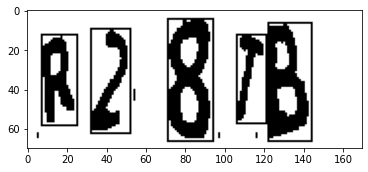

      1        1        1        1        1        

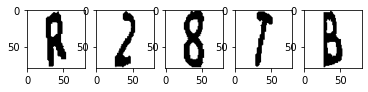

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


245
tensor([[27,  2,  8, 29, 11]])


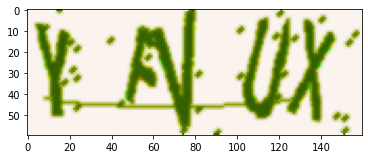

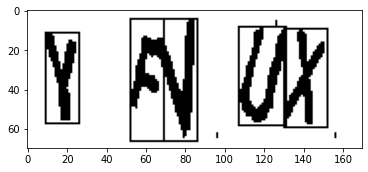

      1        2        1        1        0        

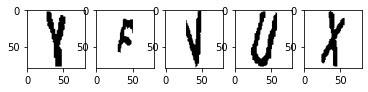

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


246
tensor([[34, 15, 31, 30, 33]])


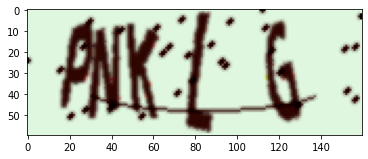

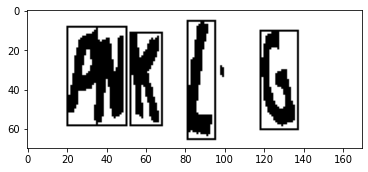

      2        1        1        1        0        

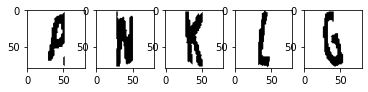

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


247
tensor([[25, 23, 20, 21, 16]])


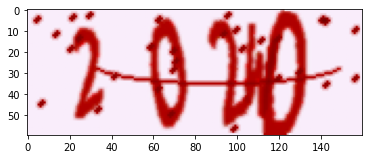

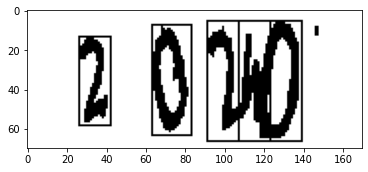

      1        1        3        0        0        

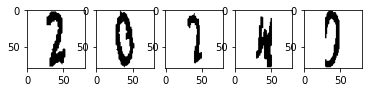

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


248
tensor([[ 2, 24,  2, 32, 24]])


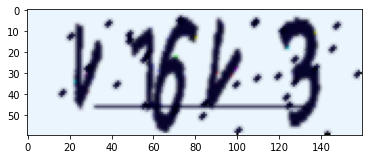

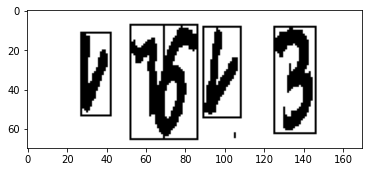

      1        2        1        1        0        

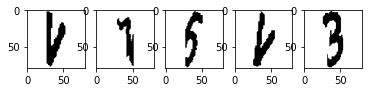

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


249
tensor([[31,  7,  6, 31,  3]])


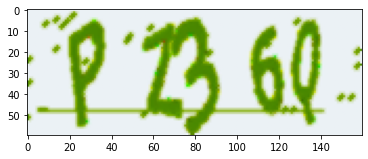

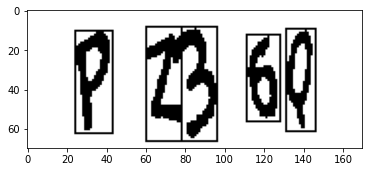

      1        2        1        1        0        

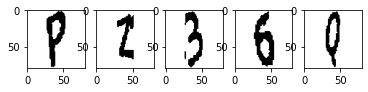

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


250
tensor([[25, 35,  3,  6, 26]])


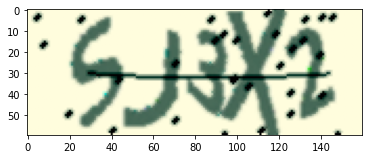

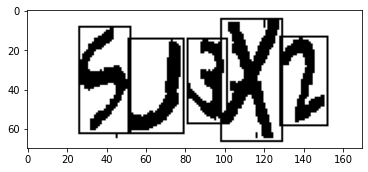

      1        1        1        1        1        

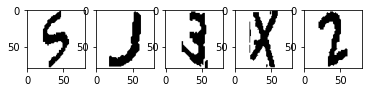

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


251
tensor([[28, 19,  3, 33,  2]])


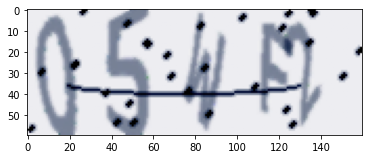

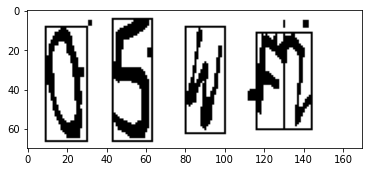

      1        1        1        2        0        

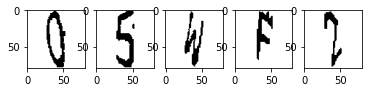

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


252
tensor([[24,  5, 32, 15,  2]])


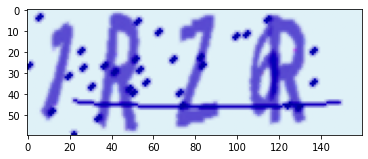

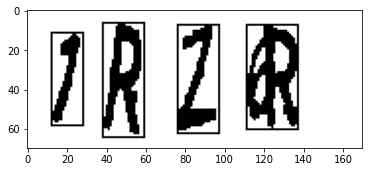

      1        1        1        2        0        

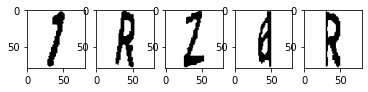

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


253
tensor([[ 1, 27, 35,  6, 27]])


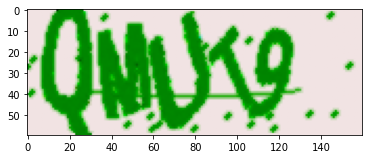

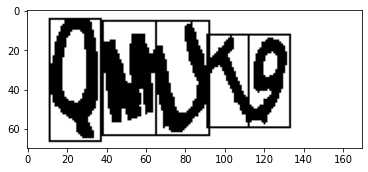

      1        2        2        0        0        

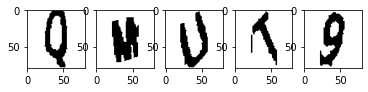

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


254
tensor([[26, 22, 30, 29,  9]])


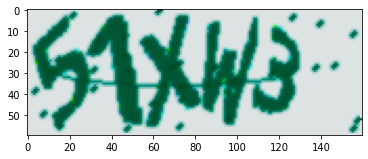

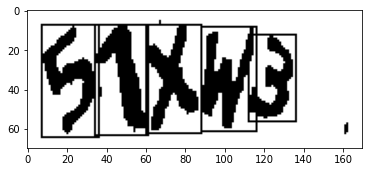

      1        1        1        1        1        

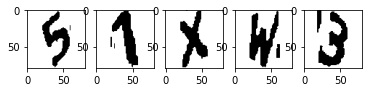

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


255
tensor([[ 5,  1, 33, 32,  3]])


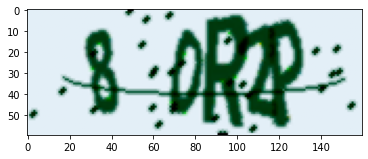

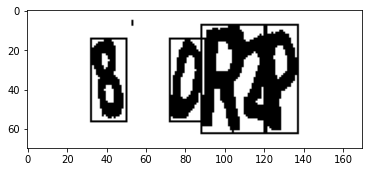

      1        1        3        0        0        

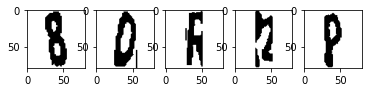

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


256
tensor([[ 8,  0, 27,  2, 25]])


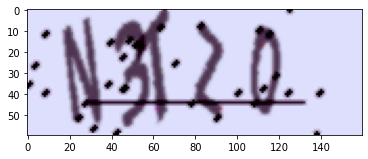

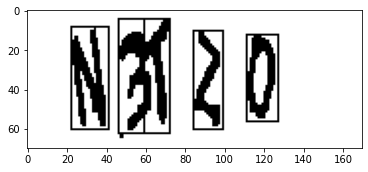

      1        2        1        1        0        

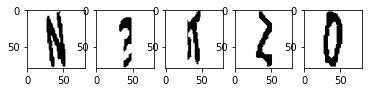

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


257
tensor([[23,  3, 29, 35, 24]])


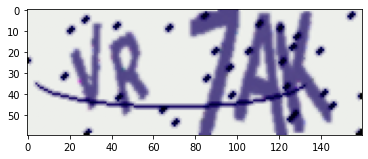

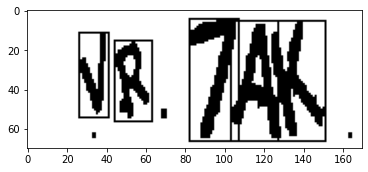

      1        1        1        2        0        

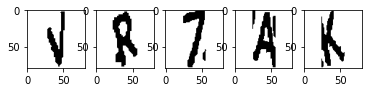

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


258
tensor([[31, 27,  7, 10, 20]])


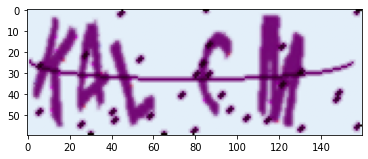

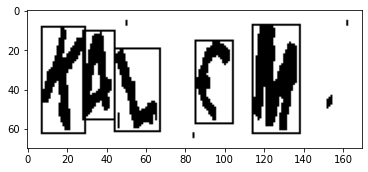

      1        1        1        1        1        

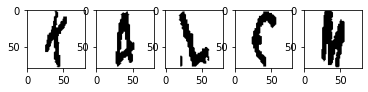

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


259
tensor([[20,  4, 21, 12, 22]])


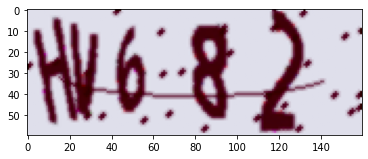

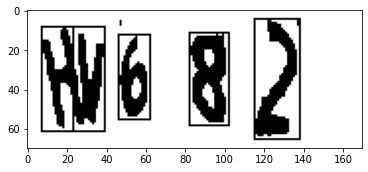

      2        1        1        1        0        

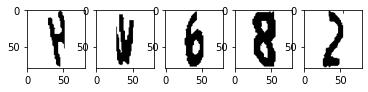

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


260
tensor([[17, 31,  6,  8,  2]])


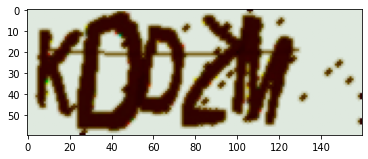

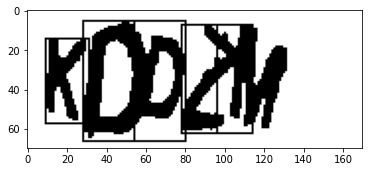

      1        2        3        0        0        

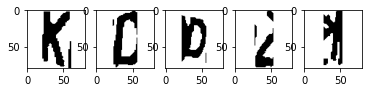

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


261
tensor([[20, 13, 13, 35, 22]])


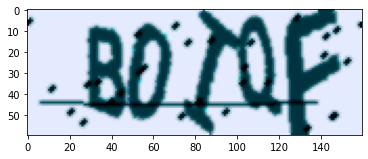

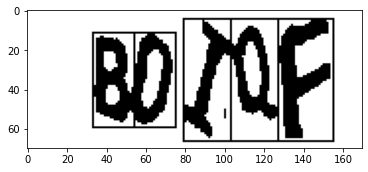

      2        2        1        0        0        

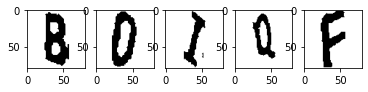

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


262
tensor([[11,  0, 18, 26, 15]])


KeyboardInterrupt: ignored

In [ ]:
"""
How To Use - getcharacterimages(images,height,width, showsegments=False)

Input = tensor(batchsize,numchannels,height,width) (see below)
Output = tensor(batchsize, numcharacters = 5, height = 80, width = 80 )
"""
train, valid, test = get_data_loaders(dataset, 1)

images_processed = 0
successful_segmentation = 0

i=0
for images, labels in test:
  if (i>200):
    print(i)
    #input dimensions should be a square
    characters = getcharacterimages(images,dheight=80,dwidth=80, showsegments=True, deeplearning=False)
    print(labels)
  i+=1

In [ ]:
"""Zipping Up the Files"""
!zip -r "/content/data_unlabelled_2Char.zip"  "/content/2Chars"


In [ ]:
!zip -r "/content/data_unlabelled_3Char.zip"  "/content/3Chars"